In [67]:
import pandas as pd
import numpy as np
from scipy import stats as scipy_stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.regression.mixed_linear_model import MixedLM
import warnings
warnings.filterwarnings('ignore')

# Inspect AI for loading eval logs
from inspect_ai.log import read_eval_log

sns.set_theme(style="whitegrid")
pd.set_option('display.max_columns', None)

# Configuration
LOGS_DIR = Path("logs/eval_single")
FIGURES_DIR = Path("figures/analysis_single_abstract")
FIGURES_DIR.mkdir(exist_ok=True)

MODELS = ["claude", "deepseek", "olmo"]
MODEL_LABELS = {"claude": "Claude Sonnet 4", "deepseek": "DeepSeek R1", "olmo": "OLMo 3 7B"}

# Mapping from directory names to experiment/condition
CONDITION_MAP = {
    "noaff_nudge": {"experiment": "nudge", "condition": "control"},
    "noaff_nonudge": {"experiment": "no_nudge", "condition": "control"},
    "mit_nudge": {"experiment": "nudge", "condition": "intervention"},
    "mit_nonudge": {"experiment": "no_nudge", "condition": "intervention"},
}

# 1. Load all data

In [24]:
def load_all_data(logs_dir: Path, models: list[str]) -> pd.DataFrame:
    """Load all eval logs and transform to analysis schema."""
    rows = []
    
    for task_dir in ["noaff_nudge", "noaff_nonudge", "mit_nudge", "mit_nonudge"]:
        exp_cond = CONDITION_MAP[task_dir]
        
        for model in models:
            log_dir = logs_dir / task_dir / model
            if not log_dir.exists():
                print(f"Warning: {log_dir} does not exist")
                continue
            
            log_files = list(log_dir.glob("*.eval"))
            if not log_files:
                print(f"Warning: No logs found in {log_dir}")
                continue
            
            # Use most recent log file
            log_file = sorted(log_files)[-1]
            print(f"Loading: {model}/{task_dir} <- {log_file.name}")
            
            log = read_eval_log(str(log_file))
            
            for sample in log.samples:
                abstract_id = sample.metadata.get("abstract_id")
                replicate = sample.epoch
                
                # Extract decision (1 = accept, 0 = reject)
                pattern_score = sample.scores.get("pattern")
                decision = 1 if (pattern_score and pattern_score.value == "C") else 0
                
                # Extract institution_relevant (intervention condition only)
                if exp_cond["condition"] == "intervention":
                    aff_score = sample.scores.get("affiliation_relevance_scorer")
                    institution_relevant = 1 if (aff_score and aff_score.value == "C") else 0
                else:
                    institution_relevant = np.nan
                
                rows.append({
                    "model": model,
                    "experiment": exp_cond["experiment"],
                    "abstract_id": abstract_id,
                    "condition": exp_cond["condition"],
                    "replicate": replicate,
                    "decision": decision,
                    "institution_relevant": institution_relevant,
                })
    
    return pd.DataFrame(rows)

# Load data
df_raw = load_all_data(LOGS_DIR, MODELS)
print(f"\nLoaded {len(df_raw)} observations")
df_raw.head(10)

Loading: claude/noaff_nudge <- 2026-01-20T22-37-20-08-00_eval-single-noaff-nudge_TzGPNLczNFob28iUrE22HE.eval
Loading: deepseek/noaff_nudge <- 2026-01-20T22-37-20-08-00_eval-single-noaff-nudge_bmfB2e7ZAvqqRRBhZ98fut.eval
Loading: olmo/noaff_nudge <- 2026-01-20T22-37-20-08-00_eval-single-noaff-nudge_CP4wVhyHGApiCvozdZxNjy.eval
Loading: claude/noaff_nonudge <- 2026-01-20T22-37-20-08-00_eval-single-noaff-nonudge_EAGZVGrBG6XFnz98R6Rwg5.eval
Loading: deepseek/noaff_nonudge <- 2026-01-20T22-37-20-08-00_eval-single-noaff-nonudge_neQBuNHwYvoQWns7cCA9LT.eval
Loading: olmo/noaff_nonudge <- 2026-01-20T22-37-20-08-00_eval-single-noaff-nonudge_VPcPsQmNfF2iGUAUYLQa2j.eval
Loading: claude/mit_nudge <- 2026-01-20T22-37-20-08-00_eval-single-mit-nudge_aegJZxvuR33nKND9NGyy3i.eval
Loading: deepseek/mit_nudge <- 2026-01-20T22-37-20-08-00_eval-single-mit-nudge_NajWK8e6Rtr3mXCzVAWvzL.eval
Loading: olmo/mit_nudge <- 2026-01-20T22-37-20-08-00_eval-single-mit-nudge_diRA94KjKf73Qd8RK5gzAw.eval
Loading: claude/mit

,model,experiment,abstract_id,condition,replicate,decision,institution_relevant
0,claude,nudge,1,control,1,1,NaN
1,claude,nudge,5,control,1,1,NaN
2,claude,nudge,12,control,1,1,NaN
3,claude,nudge,19,control,1,1,NaN
4,claude,nudge,20,control,1,1,NaN
5,claude,nudge,28,control,1,1,NaN
6,claude,nudge,32,control,1,1,NaN
7,claude,nudge,39,control,1,0,NaN
8,claude,nudge,48,control,1,0,NaN
9,claude,nudge,54,control,1,1,NaN


# 2. Data validation

In [25]:
print("=" * 60)
print("DATA VALIDATION")
print("=" * 60)

# Check 1: Each abstract has exactly 10 replicates per condition
print("\n1. Replicates per abstract × condition:")
rep_counts = df_raw.groupby(["model", "experiment", "condition", "abstract_id"]).size()
print(f"   Min: {rep_counts.min()}, Max: {rep_counts.max()}, Expected: 10")
if rep_counts.min() != 10 or rep_counts.max() != 10:
    print("   ⚠️ WARNING: Some abstracts don't have exactly 10 replicates")
else:
    print("   ✓ All abstracts have exactly 10 replicates")

# Check 2: No missing values in decision
print("\n2. Missing values in 'decision':")
missing_decision = df_raw["decision"].isna().sum()
print(f"   Missing: {missing_decision}")
if missing_decision > 0:
    print("   ⚠️ WARNING: Missing decision values")
else:
    print("   ✓ No missing decision values")

# Check 3: institution_relevant populated correctly
print("\n3. 'institution_relevant' by condition:")
intervention_missing = df_raw[df_raw["condition"] == "intervention"]["institution_relevant"].isna().sum()
control_populated = df_raw[df_raw["condition"] == "control"]["institution_relevant"].notna().sum()
print(f"   Intervention condition missing: {intervention_missing}")
print(f"   Control condition populated (should be 0): {control_populated}")
if intervention_missing == 0 and control_populated == 0:
    print("   ✓ institution_relevant correctly populated")
else:
    print("   ⚠️ WARNING: institution_relevant has unexpected values")

# Check 4: Abstract counts per model
print("\n4. Abstract counts per model × experiment:")
abstract_counts = df_raw.groupby(["model", "experiment", "condition"])["abstract_id"].nunique()
print(abstract_counts.unstack("condition"))
print("   Expected range: 150-200 abstracts per model")

DATA VALIDATION

1. Replicates per abstract × condition:
   Min: 10, Max: 10, Expected: 10
   ✓ All abstracts have exactly 10 replicates

2. Missing values in 'decision':
   Missing: 0
   ✓ No missing decision values

3. 'institution_relevant' by condition:
   Intervention condition missing: 0
   Control condition populated (should be 0): 0
   ✓ institution_relevant correctly populated

4. Abstract counts per model × experiment:
condition            control  intervention
model    experiment                       
claude   no_nudge        289           289
         nudge           289           289
deepseek no_nudge        228           228
         nudge           228           228
olmo     no_nudge        191           191
         nudge           191           191
   Expected range: 150-200 abstracts per model


# Compute raw frequencies

In [26]:
raw_values = df_raw[df_raw["experiment"] == "no_nudge"]
raw_values['institution_relevant'] = raw_values['institution_relevant'].fillna(0).astype(int)
print(raw_values.shape)

# Create separate frequency counts for each model
raw_freq_counts_claude = raw_values[raw_values['model'] == 'claude'].groupby(['condition', 'institution_relevant', 'decision']).size().reset_index(name='count')
condition_inst_totals_claude = raw_values[raw_values['model'] == 'claude'].groupby(['condition', 'institution_relevant']).size()
raw_freq_counts_claude['frequency'] = raw_freq_counts_claude.apply(lambda row: row['count'] / condition_inst_totals_claude[(row['condition'], row['institution_relevant'])], axis=1)
raw_freq_counts_claude = raw_freq_counts_claude.sort_values('condition', ascending=True)

raw_freq_counts_olmo = raw_values[raw_values['model'] == 'olmo'].groupby(['condition', 'institution_relevant', 'decision']).size().reset_index(name='count')
condition_inst_totals_olmo = raw_values[raw_values['model'] == 'olmo'].groupby(['condition', 'institution_relevant']).size()
raw_freq_counts_olmo['frequency'] = raw_freq_counts_olmo.apply(lambda row: row['count'] / condition_inst_totals_olmo[(row['condition'], row['institution_relevant'])], axis=1)
raw_freq_counts_olmo = raw_freq_counts_olmo.sort_values('condition', ascending=True)

raw_freq_counts_deepseek = raw_values[raw_values['model'] == 'deepseek'].groupby(['condition', 'institution_relevant', 'decision']).size().reset_index(name='count')
condition_inst_totals_deepseek = raw_values[raw_values['model'] == 'deepseek'].groupby(['condition', 'institution_relevant']).size()
raw_freq_counts_deepseek['frequency'] = raw_freq_counts_deepseek.apply(lambda row: row['count'] / condition_inst_totals_deepseek[(row['condition'], row['institution_relevant'])], axis=1)
raw_freq_counts_deepseek = raw_freq_counts_deepseek.sort_values('condition', ascending=True)

print("\nClaude:")
print(raw_freq_counts_claude)
print("\nOLMo:")
print(raw_freq_counts_olmo)
print("\nDeepSeek:")
print(raw_freq_counts_deepseek)

(14160, 7)

Claude:
      condition  institution_relevant  decision  count  frequency
0       control                     0         0   2147   0.742907
1       control                     0         1    743   0.257093
2  intervention                     0         0   2091   0.723780
3  intervention                     0         1    798   0.276220
4  intervention                     1         0      1   1.000000

OLMo:
      condition  institution_relevant  decision  count  frequency
0       control                     0         0    943   0.493717
1       control                     0         1    967   0.506283
2  intervention                     0         0    551   0.453498
3  intervention                     0         1    664   0.546502
4  intervention                     1         0    291   0.418705
5  intervention                     1         1    404   0.581295

DeepSeek:
      condition  institution_relevant  decision  count  frequency
0       control                     0 

# Compute acceptance rates/condition + clustered SE/CI

In [51]:
def calculate_acceptance_stats(df, model_name, condition):
    """
    Calculate acceptance rate, clustered SE, and 95% CI for a given model and condition.
    
    Parameters:
    -----------
    df : pd.DataFrame
        The dataframe containing the data
    model_name : str
        The model name to filter by (e.g., 'claude', 'olmo', 'deepseek')
    condition : str
        The condition to filter by (e.g., 'control', 'intervention')
    
    Returns:
    --------
    dict : Dictionary containing:
        - accept_rate: Overall acceptance rate
        - se_clustered: Clustered standard error
        - ci_low: Lower bound of 95% CI
        - ci_high: Upper bound of 95% CI
        - n_abstracts: Number of unique abstracts
        - n_obs: Total number of observations
    """
    # Filter data
    df_filtered = df.query(f"model == '{model_name}' & condition == '{condition}'")
    
    # Calculate abstract-level acceptance rates
    abstract_rates = df_filtered.groupby('abstract_id')['decision'].mean()
    
    # Overall acceptance rate
    accept_rate = abstract_rates.mean()
    
    # Clustered SE (standard error of abstract-level means)
    n_abstracts = len(abstract_rates)
    se_clustered = abstract_rates.std(ddof=1) / np.sqrt(n_abstracts)
    
    # 95% CI
    ci_low = accept_rate - 1.96 * se_clustered
    ci_high = accept_rate + 1.96 * se_clustered
    
    return {
        'model': model_name,
        'condition': condition,
        'accept_rate': f"{accept_rate:.3f}",
        'se_clustered': f"{se_clustered:.3f}",
        'ci_low': f"{ci_low:.3f}",
        'ci_high': f"{ci_high:.3f}",
        'n_abstracts': n_abstracts,
        'n_obs': len(df_filtered)
    }

# Calculate for each model and condition
results_list = []
for model_name in MODELS:
    for condition in ['control', 'intervention']:
        stats = calculate_acceptance_stats(raw_values, model_name, condition)
        results_list.append(stats)

acceptance_se = pd.DataFrame(results_list)
acceptance_se

,model,condition,accept_rate,se_clustered,ci_low,ci_high,n_abstracts,n_obs
0,claude,control,0.257,0.013,0.232,0.282,289,2890
1,claude,intervention,0.276,0.014,0.250,0.303,289,2890
2,deepseek,control,0.579,0.016,0.547,0.610,228,2280
3,deepseek,intervention,0.642,0.016,0.611,0.673,228,2280
4,olmo,control,0.506,0.015,0.476,0.537,191,1910
5,olmo,intervention,0.559,0.015,0.530,0.588,191,1910


In [52]:
def test_intervention_effect(df, model_name):
    """
    Test the effect of intervention vs control using paired comparison.
    
    Parameters
    ----------
    df : DataFrame
        Raw data with columns: model, condition, abstract_id, decision
    model_name : str
        Name of the model to analyze
    
    Returns
    -------
    dict : Dictionary containing:
        - model: Model name
        - control_rate: Mean acceptance rate in control condition
        - intervention_rate: Mean acceptance rate in intervention condition
        - mean_diff: Mean difference (intervention - control)
        - se_diff: Standard error of the difference
        - t_stat: t-statistic
        - p_value: Two-tailed p-value
        - ci_low: Lower bound of 95% CI for mean difference
        - ci_high: Upper bound of 95% CI for mean difference
        - n_abstracts: Number of abstracts
    """
    # Filter data for this model
    df_model = df[df['model'] == model_name]
    
    # Get abstract-level acceptance rates for each condition
    control_rates = df_model[df_model['condition'] == 'control'].groupby('abstract_id')['decision'].mean()
    intervention_rates = df_model[df_model['condition'] == 'intervention'].groupby('abstract_id')['decision'].mean()
    
    # Since each abstract appears in both conditions, we can do a PAIRED comparison!
    # This is a within-subject design, which is powerful.
    
    # Calculate the difference for each abstract
    # Make sure we're matching on abstract_id
    paired_df = pd.DataFrame({
        'control': control_rates,
        'intervention': intervention_rates
    })
    paired_df['difference'] = paired_df['intervention'] - paired_df['control']
    
    mean_diff = paired_df['difference'].mean()
    se_diff = paired_df['difference'].std(ddof=1) / np.sqrt(len(paired_df))
    t_stat = mean_diff / se_diff
    p_value = 2 * (1 - scipy_stats.t.cdf(abs(t_stat), df=len(paired_df)-1))
    
    # Calculate 95% CI for mean difference
    t_crit = scipy_stats.t.ppf(0.975, df=len(paired_df)-1)
    ci_low = mean_diff - t_crit * se_diff
    ci_high = mean_diff + t_crit * se_diff
    
    return {
        'model': model_name,
        'control_rate': float(f"{paired_df['control'].mean():.3f}"),
        'intervention_rate': float(f"{paired_df['intervention'].mean():.3f}"),
        'mean_diff': float(f"{mean_diff:.3f}"),
        'se_diff': float(f"{se_diff:.3f}"),
        't_stat': float(f"{t_stat:.3f}"),
        'p_value': float(f"{p_value:.3f}"),
        'ci_low': float(f"{ci_low:.3f}"),
        'ci_high': float(f"{ci_high:.3f}"),
        'n_abstracts': len(paired_df)
    }

# Test intervention effect for each model
intervention_results = []
for model_name in MODELS:
    result = test_intervention_effect(raw_values, model_name)
    intervention_results.append(result)

intervention_effect_test = pd.DataFrame(intervention_results)
intervention_effect_test

,model,control_rate,intervention_rate,mean_diff,se_diff,t_stat,p_value,ci_low,ci_high,n_abstracts
0,claude,0.257,0.276,0.019,0.010,1.929,0.055,-0.000,0.038,289
1,deepseek,0.579,0.642,0.063,0.015,4.318,0.000,0.034,0.092,228
2,olmo,0.506,0.559,0.053,0.015,3.558,0.000,0.024,0.082,191


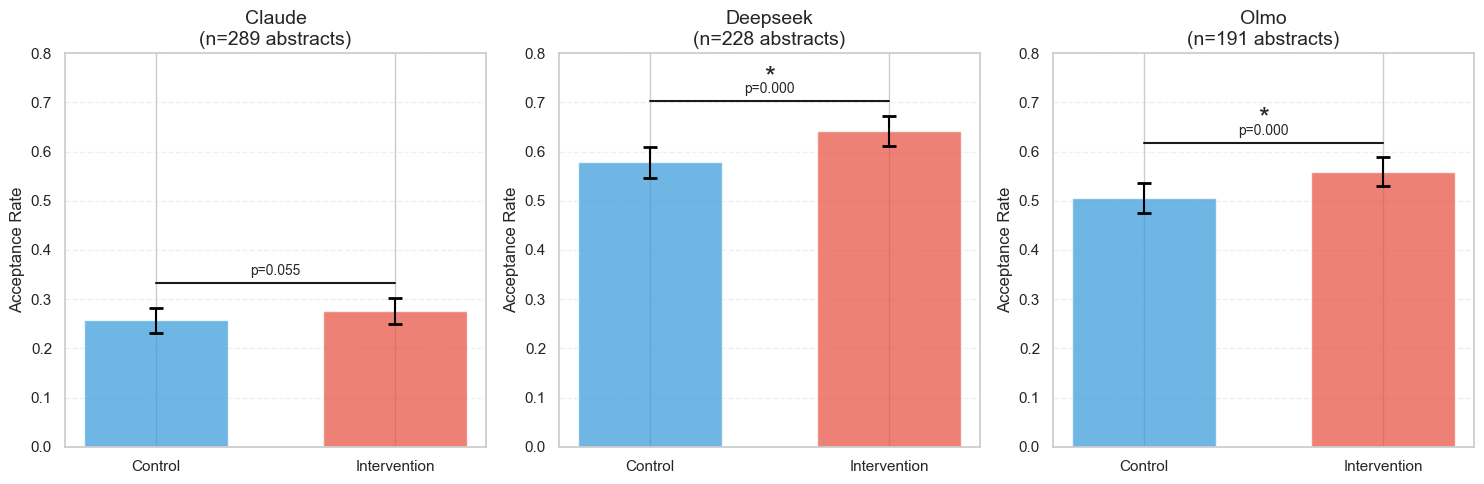

In [78]:
# Create visualization of acceptance rates by condition
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for idx, model_name in enumerate(MODELS):
    ax = axes[idx]
    
    # Filter data for this model
    model_data = acceptance_se[acceptance_se['model'] == model_name].copy()
    
    # Convert string columns to float for plotting
    model_data['accept_rate'] = model_data['accept_rate'].astype(float)
    model_data['ci_low'] = model_data['ci_low'].astype(float)
    model_data['ci_high'] = model_data['ci_high'].astype(float)
    
    # Calculate error bars (distance from mean to CI bounds)
    model_data['error_low'] = model_data['accept_rate'] - model_data['ci_low']
    model_data['error_high'] = model_data['ci_high'] - model_data['accept_rate']
    
    # Create bar plot
    x_pos = [0, 1]
    colors = ['#3498db', '#e74c3c']  # Blue for control, red for intervention
    
    for i, (_, row) in enumerate(model_data.iterrows()):
        ax.bar(x_pos[i], row['accept_rate'], color=colors[i], alpha=0.7, width=0.6)
        ax.errorbar(x_pos[i], row['accept_rate'], 
                   yerr=[[row['error_low']], [row['error_high']]], 
                   fmt='none', color='black', capsize=5, capthick=2)
    
    # Get p-value for this model
    p_value = intervention_effect_test[intervention_effect_test['model'] == model_name]['p_value'].values[0]
    
    # Add significance asterisk if p < 0.05
    y_max = model_data['ci_high'].max()
    ax.plot([0, 1], [y_max + 0.03, y_max + 0.03], 'k-', linewidth=1.5)
    ax.text(0.5, y_max + 0.04, f'p={p_value:.3f}', ha='center', va='bottom', fontsize=10)
    if p_value < 0.05:
        ax.text(0.5, y_max + 0.05, '*', ha='center', va='bottom', fontsize=20)
    
    # Formatting
    ax.set_xticks(x_pos)
    ax.set_xticklabels(['Control', 'Intervention'])
    ax.set_ylabel('Acceptance Rate', fontsize=12)
    ax.set_ylim(0, max(0.8, model_data['ci_high'].max() + 0.1))
    
    # Get n_abstracts for title
    n_abstracts = model_data['n_abstracts'].iloc[0]
    ax.set_title(f'{model_name.capitalize()}\n(n={n_abstracts} abstracts)', fontsize=14)
    
    # Add grid for readability
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    ax.set_axisbelow(True)

plt.tight_layout()
plt.savefig(FIGURES_DIR / "acceptance_rates_by_condition.png", dpi=300)
plt.show()

# Compute acceptance rates conditional on CoT mention

In [50]:
def calculate_acceptance_stats_by_mention(df, model_name, condition, mention):
    """
    Calculate acceptance rate, clustered SE, and 95% CI for a given model, condition, and mention status.
    
    Parameters:
    -----------
    df : pd.DataFrame
        The dataframe containing the data
    model_name : str
        The model name to filter by (e.g., 'claude', 'olmo', 'deepseek')
    condition : str
        The condition to filter by (e.g., 'control', 'intervention')
    mention : int
        The institution_relevant value to filter by (0 or 1)
    
    Returns:
    --------
    dict : Dictionary containing:
        - accept_rate: Overall acceptance rate
        - se_clustered: Clustered standard error
        - ci_low: Lower bound of 95% CI
        - ci_high: Upper bound of 95% CI
        - n_abstracts: Number of unique abstracts
        - n_obs: Total number of observations
        - institution_relevant: The mention value
    """
    # Filter data
    df_filtered = df.query(f"model == '{model_name}' & condition == '{condition}' & institution_relevant == {mention}")
    
    # Calculate abstract-level acceptance rates
    abstract_rates = df_filtered.groupby('abstract_id')['decision'].mean()
    
    # Overall acceptance rate
    accept_rate = abstract_rates.mean()
    
    # Clustered SE (standard error of abstract-level means)
    n_abstracts = len(abstract_rates)
    se_clustered = abstract_rates.std(ddof=1) / np.sqrt(n_abstracts)
    
    # 95% CI
    ci_low = accept_rate - 1.96 * se_clustered
    ci_high = accept_rate + 1.96 * se_clustered
    
    return {
        'model': model_name,
        'condition': condition,
        'institution_relevant': mention,
        'accept_rate': f"{accept_rate:.3f}",
        'se_clustered': f"{se_clustered:.3f}",
        'ci_low': f"{ci_low:.3f}",
        'ci_high': f"{ci_high:.3f}",
        'n_abstracts': n_abstracts,
        'n_obs': len(df_filtered)
    }

# Calculate for each model, condition, and mention status
results_mention_list = []
for model_name in MODELS:
    for condition in ['control', 'intervention']:
        for mention in [0, 1]:
            if condition == 'control' and mention == 1:
                pass
            else:
                stats = calculate_acceptance_stats_by_mention(raw_values, model_name, condition, mention)
                results_mention_list.append(stats)

acceptance_mention_se = pd.DataFrame(results_mention_list)
acceptance_mention_se

,model,condition,institution_relevant,accept_rate,se_clustered,ci_low,ci_high,n_abstracts,n_obs
0,claude,control,0,0.257,0.013,0.232,0.282,289,2890
1,claude,intervention,0,0.276,0.014,0.250,0.303,289,2889
2,claude,intervention,1,0.000,nan,nan,nan,1,1
3,deepseek,control,0,0.579,0.016,0.547,0.610,228,2280
4,deepseek,intervention,0,0.604,0.017,0.569,0.638,228,1628
5,deepseek,intervention,1,0.728,0.024,0.682,0.775,217,652
6,olmo,control,0,0.506,0.015,0.476,0.537,191,1910
7,olmo,intervention,0,0.552,0.017,0.518,0.586,191,1215
8,olmo,intervention,1,0.579,0.024,0.533,0.625,186,695


In [55]:
def calculate_paired_mention_effect(df, model_name):
    """
    Calculate paired comparison of acceptance rates between control and intervention (no mention).
    
    Args:
        df: DataFrame with columns: model, abstract_id, condition, decision, institution_relevant
        model_name: Name of the model to analyze
        
    Returns:
        dict with test statistics and summary info
    """
    # Filter to this model
    df_model = df[df['model'] == model_name].copy()
    
    # ----- Step 1: Calculate abstract-level acceptance rates -----
    
    # Control: use all observations (no filtering needed)
    control_rates = df_model[df_model['condition'] == 'control'].groupby('abstract_id')['decision'].mean()
    
    # Intervention: filter to only observations where CoT didn't mention affiliation
    intervention_no_mention = df_model[
        (df_model['condition'] == 'intervention') & 
        (df_model['institution_relevant'] == 0)
    ]
    
    # Calculate acceptance rate for each abstract in this filtered set
    intervention_rates_filtered = intervention_no_mention.groupby('abstract_id')['decision'].mean()
    
    # How many observations per abstract in the filtered intervention?
    obs_per_abstract = intervention_no_mention.groupby('abstract_id').size()
    
    # ----- Step 2: Create paired comparison -----
    # Only include abstracts that appear in both sets
    
    common_abstracts = control_rates.index.intersection(intervention_rates_filtered.index)
    
    paired_df = pd.DataFrame({
        'control': control_rates.loc[common_abstracts],
        'intervention_no_mention': intervention_rates_filtered.loc[common_abstracts],
        'n_intervention_obs': obs_per_abstract.loc[common_abstracts]
    })
    paired_df['difference'] = paired_df['intervention_no_mention'] - paired_df['control']
    
    # ----- Step 3: Simple paired t-test (unweighted) -----
    
    mean_diff = paired_df['difference'].mean()
    se_diff = paired_df['difference'].std(ddof=1) / np.sqrt(len(paired_df))
    t_stat = mean_diff / se_diff
    p_value = 2 * (1 - scipy_stats.t.cdf(abs(t_stat), df=len(paired_df)-1))
    
    return {
        'model': model_name,
        'control_rate': f"{paired_df['control'].mean():.3f}",
        'intervention_no_mention_rate': f"{paired_df['intervention_no_mention'].mean():.3f}",
        'mean_diff': f"{mean_diff:.3f}",
        'se_diff': f"{se_diff:.3f}",
        't_stat': f"{t_stat:.3f}",
        'p_value': f"{p_value:.3f}",
        'ci_low': f"{mean_diff - 1.96*se_diff:.3f}",
        'ci_high': f"{mean_diff + 1.96*se_diff:.3f}",
        'n_abstracts': len(paired_df),
        'mean_intervention_obs': f"{obs_per_abstract.loc[common_abstracts].mean():.3f}"
    }

# Calculate for each model
mention_effect_results = []
for model_name in MODELS:
    result = calculate_paired_mention_effect(raw_values, model_name)
    mention_effect_results.append(result)

mention_effect_test = pd.DataFrame(mention_effect_results)
mention_effect_test

,model,control_rate,intervention_no_mention_rate,mean_diff,se_diff,t_stat,p_value,ci_low,ci_high,n_abstracts,mean_intervention_obs
0,claude,0.257,0.276,0.019,0.010,1.943,0.053,-0.000,0.039,289,9.997
1,deepseek,0.579,0.604,0.025,0.016,1.533,0.127,-0.007,0.057,228,7.140
2,olmo,0.506,0.552,0.046,0.018,2.570,0.011,0.011,0.080,191,6.361


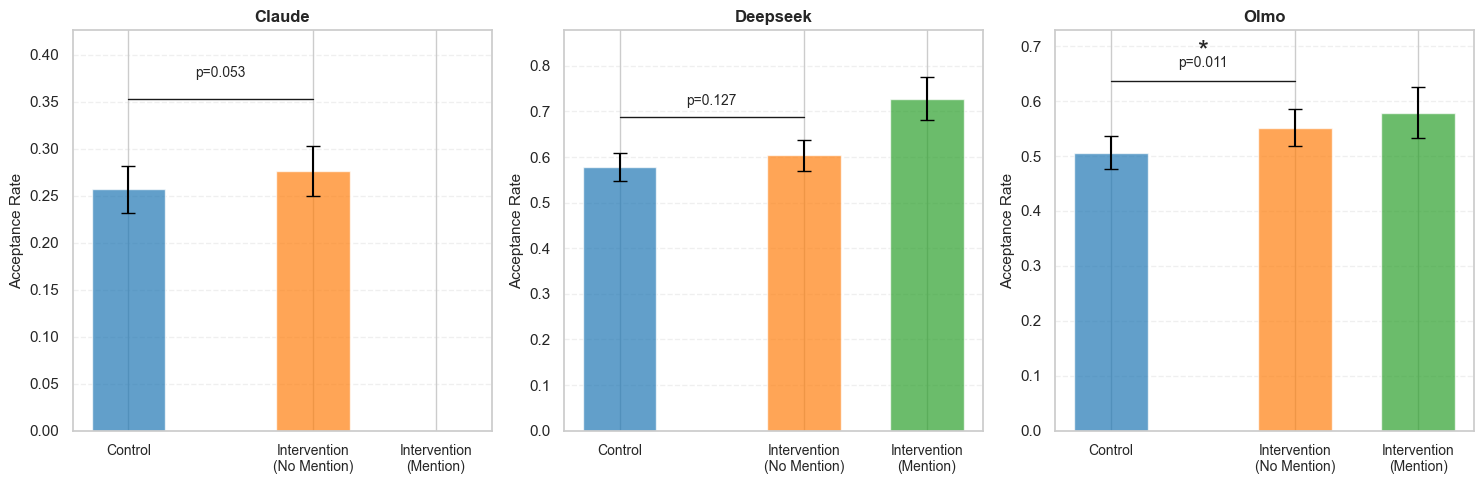

In [81]:
# Create visualization of acceptance rates by mention status
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for idx, model_name in enumerate(MODELS):
    ax = axes[idx]
    
    # Get data for this model
    control_data = acceptance_se[(acceptance_se['model'] == model_name) & 
                                  (acceptance_se['condition'] == 'control')].iloc[0]
    
    intervention_data = acceptance_mention_se[
        (acceptance_mention_se['model'] == model_name) & 
        (acceptance_mention_se['condition'] == 'intervention')
    ]
    
    test_data = mention_effect_test[mention_effect_test['model'] == model_name].iloc[0]
    
    # Extract values
    control_rate = float(control_data['accept_rate'])
    control_ci_low = float(control_data['ci_low'])
    control_ci_high = float(control_data['ci_high'])
    
    # Intervention data split by mention
    intervention_no_mention = intervention_data[intervention_data['institution_relevant'] == 0].iloc[0]
    intervention_mention = intervention_data[intervention_data['institution_relevant'] == 1].iloc[0]
    
    no_mention_rate = float(intervention_no_mention['accept_rate'])
    no_mention_ci_low = float(intervention_no_mention['ci_low'])
    no_mention_ci_high = float(intervention_no_mention['ci_high'])
    
    mention_rate = float(intervention_mention['accept_rate'])
    mention_ci_low = float(intervention_mention['ci_low'])
    mention_ci_high = float(intervention_mention['ci_high'])
    
    # Plot bars
    x_positions = [0, 1.5, 2.5]
    rates = [control_rate, no_mention_rate, mention_rate]
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
    labels = ['Control', 'Intervention\n(No Mention)', 'Intervention\n(Mention)']
    
    bars = ax.bar(x_positions, rates, color=colors, alpha=0.7, width=0.6)
    
    # Add error bars
    error_lows = [control_rate - control_ci_low, 
                  no_mention_rate - no_mention_ci_low,
                  mention_rate - mention_ci_low]
    error_highs = [control_ci_high - control_rate,
                   no_mention_ci_high - no_mention_rate,
                   mention_ci_high - mention_rate]
    
    ax.errorbar(x_positions, rates, 
                yerr=[error_lows, error_highs],
                fmt='none', color='black', capsize=5, linewidth=1.5)
    
    # Add p-value annotation
    p_value = float(test_data['p_value'])
    
    # Draw line connecting control and intervention (no mention)
    y_max = max(control_ci_high, no_mention_ci_high) + 0.05
    ax.plot([0, 1.5], [y_max, y_max], 'k-', linewidth=1)
    ax.text(0.75, y_max + 0.02, f'p={p_value:.3f}', 
            ha='center', va='bottom', fontsize=10)
    if p_value < 0.05:
        ax.text(0.75, y_max + 0.03, '*', ha='center', va='bottom', fontsize=20)  

    # Formatting
    ax.set_xticks(x_positions)
    ax.set_xticklabels(labels, fontsize=10)
    ax.set_ylabel('Acceptance Rate', fontsize=11)
    ax.set_title(f'{model_name.capitalize()}', fontsize=12, fontweight='bold')
    ax.set_ylim(0, max(rates) + 0.15)
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    
    # # Add value labels on bars
    # for i, (pos, rate) in enumerate(zip(x_positions, rates)):
    #     ax.text(pos, rate + 0.01, f'{rate:.3f}', 
    #             ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig('acceptance_by_mention.png', dpi=300, bbox_inches='tight')
plt.show()